In [1]:
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import get_window

# Abort

In [305]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/')

['LERFUJI_2024-10-17_01-05-01.npz',
 'LERFUJI_2024-10-10_22-11-36.npz',
 'LERFUJI_2024-10-15_11-30-38.npz',
 'LERFUJI_2024-10-10_21-29-54.npz',
 'LERFUJI_2024-10-13_11-42-07.npz',
 'LERFUJI_2024-10-17_09-02-58.npz',
 'LERFUJI_2024-10-13_12-47-29.npz',
 'LERFUJI_2024-10-16_01-06-09.npz',
 'LERFUJI_2024-10-14_00-14-04.npz',
 'LERFUJI_2024-10-15_21-28-08.npz',
 'LERFUJI_2024-10-16_08-57-48.npz',
 'LERFUJI_2024-10-13_14-34-59.npz',
 'LERFUJI_2024-10-14_11-04-39.npz',
 'LERFUJI_2024-10-17_00-58-37.npz',
 'LERFUJI_2024-10-16_07-17-11.npz',
 'LERFUJI_2024-10-15_23-43-13.npz',
 'LERFUJI_2024-10-14_00-35-00.npz',
 'LERFUJI_2024-10-15_20-22-59.npz',
 'LERFUJI_2024-10-15_10-14-14.npz',
 'LERFUJI_2024-10-10_21-12-23.npz',
 'LERFUJI_2024-10-16_04-52-14.npz',
 'LERFUJI_2024-10-15_20-56-49.npz',
 'LERFUJI_2024-10-13_00-10-19.npz',
 'LERFUJI_2024-10-14_01-44-58.npz',
 'LERFUJI_2024-10-15_19-08-53.npz',
 'LERFUJI_2024-10-15_10-21-29.npz',
 'LERFUJI_2024-10-15_08-37-16.npz',
 'LERFUJI_2024-10-13_03-50-4

In [3]:
def make_mastdplot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    X_pos=npz_kw['X_Pos']
    X_ma=npz_kw['X_MA']
    X_std=npz_kw['X_STD']
    #X_valid=npz_kw['X_valid']
    Y_pos=npz_kw['Y_Pos']
    Y_ma=npz_kw['Y_MA']
    Y_std=npz_kw['Y_STD']
    #Y_valid=npz_kw['Y_valid']
    #iv=npz_kw['Injection_Veto']
    abortflag=npz_kw['AbortFlag']


    if filename=="LERFUJI_2024-10-16_08-57-48.npz":
        X_std=np.zeros(len(X_pos))
        X_delta=np.zeros(len(X_sum))
    if filename=="LERFUJI_2024-10-15_19-08-53.npz":
        X_sum=np.zeros(len(X_delta))
    if filename=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))
    timesteps=np.arange(len(X_pos))/254.5
    timesteps=timesteps-timesteps[-1]

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)

    shinpuku_X=df['result_diff'].max()-df['result_diff'].min()

    #df['charge_ratio'] = np.where(df['X_sum'] > threshold,df['X_sum'] / df['X_sum'].shift(51200), np.nan)
    #chargeloss=df[df['charge_ratio'] >= 0.5]['charge_ratio'].min()
    #array = df['charge_ratio'].to_numpy()         # 列をNumPy配列に変換
    #filtered_array = array[~np.isnan(array)]  # np.nanを削除
    #print(filtered_array)
    #plt.plot(filtered_array)
    #plt.show()
    #------------------
    signal = df['result_interp'].values
    signal=signal[~np.isnan(signal)]
    if len(signal)==0:
        return 0,0,0,0,[0],[0]
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)


    condition = df['result_ma_diff'] > df['std_shifted']*0.5
    first_row = df[condition].head(1)
    # その行のColumn3の値を取得
    exceed_x=0
    if not first_row.empty:
        exceed_x = first_row['x'].values[0]

    if len(df)==0:
        return 0,0,0,0,[0],[0]
    df['x']=df['x']-df['x'].iloc[-1]

    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,6))
    ax1.set_title(f'{filename}')
    #ax1.plot(timesteps,X_pos,label='X position')
    #ax1.plot(timesteps,X_ma/500,label='MA/500')
    #ax1.plot(timesteps,X_std/500,label='STD/500')
    #ax1.plot(timesteps,iv,label='injection veto')
    #ax1.plot(timesteps,abortflag/2,label='AbortFlag')

    ax1.scatter(df['x'],df['result_diff']*16.58/5,label='X Position',c='red',s=1)
    #ax1.plot(df['x'], df['result_ma_diff']*20, label='MA')
    #ax1.plot(df['x'], df['std_shifted']*20, label='STD')
    
    ax1.set_ylim(-0.8,0.8)
    ax1.grid()
    ax1.set_ylabel('X position (mm)')
    ax1.legend()

    ####################
    
    #ax2.plot(timesteps,Y_pos,label='Y position')
    #ax2.plot(timesteps,Y_ma/500,label='MA/500')
    #ax2.plot(timesteps,Y_std/500,label='STD/500')
    #ax2.plot(timesteps,iv,label='injection veto')
    #ax2.plot(timesteps,abortflag/2,label='AbortFlag')

    
    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=4000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)

    shinpuku_Y=df['result_diff'].max()-df['result_diff'].min()
    
    #------------------
    signaly = df['result_interp'].values
    signaly=signaly[~np.isnan(signaly)]
    if len(signaly)==0:
        return 0,0,0,0,[0],[0]
    fft_resulty = np.fft.fft(signaly)
    fft_freqsy = np.fft.fftfreq(len(signaly),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqsy = fft_freqsy[:len(fft_freqsy)//2]
    positive_ffty = np.abs(fft_resulty[:len(fft_resulty)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    condition = df['result_ma_diff'] > df['std_shifted']*0.5
    first_row = df[condition].head(1)
    # その行のColumn3の値を取得
    exceed_y=0
    if not first_row.empty:
        exceed_y = first_row['x'].values[0]

    if len(df)==0:
        return 0, 0,0,0,[0],[0]

    df['x']=df['x']-df['x'].iloc[-1]

    ax2.scatter(df['x'],df['result_diff']*16.58/5,label='Y Position', c='red',s=1)
    #ax2.plot(df['x'], df['result_ma_diff']*20, label='MA')
    #ax2.plot(df['x'], df['std_shifted']*20, label='STD')

    ax2.grid()
    ax2.legend()
    ax2.set_ylim(-0.8,0.8)
    ax2.set_ylabel("Y position (mm)")
    plt.xlim(-800,0)
    ax2.set_xlabel("Time (us)")
    plt.savefig(f'abort_picture/{filename[8:-4]}.png',dpi=100)
    #plt.show()
    plt.close()

    ######################################

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs, positive_fft)
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    #plt.xscale('log')
    plt.savefig(f'abort_picture/{filename[8:-4]}_fft.png',dpi=100)
    plt.close()




   # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signal
    x = np.arange(len(signal))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]#* window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)


    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Xpos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,50)
    # プロット表示
    plt.savefig(f'abort_picture/{filename[8:-4]}_fft3Dx.png',dpi=100)
    plt.close()

    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')

    #plt.ylim(240,254)
    plt.savefig(f'abort_picture/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    plt.figure(figsize=(16, 6))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')
    plt.ylim(254,244)
    plt.savefig(f'abort_picture/{filename[8:-4]}_fftheatmapx_expanded.png',dpi=100)
    plt.close()

    time_axis=window_times-window_times[-1]-10
    spectrum=fft_results.T[2508]
    plt.figure(figsize=(14,3))
    plt.plot(time_axis,spectrum,'o-')
    plt.ylim(0,10)
    plt.grid()
    plt.xlabel('Time (us)')
    plt.savefig(f'abort_picture/{filename[8:-4]}_amplitude_suii.png',dpi=100)
    plt.close()


    #print(fft_results)
    #plt.plot(fft_results.T[np.argmax(positive_fft[12:])+12])
    #plt.show()

    ######################################3

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqsy, positive_ffty)
    plt.title('FFT of Ypos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    #plt.xscale('log')
    plt.savefig(f'abort_picture/{filename[8:-4]}_ffty.png',dpi=100)
    plt.close()
    

    
    # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signaly
    x = np.arange(len(signaly))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]# * window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)

    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Ypos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,10)
    # プロット表示
    plt.savefig(f'abort_picture/{filename[8:-4]}_fft3Dy.png',dpi=100)
    plt.close()
    
    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Ypos')

    plt.savefig(f'abort_picture/{filename[8:-4]}_fftheatmapy.png',dpi=100)
    plt.close()


    
    
    return exceed_x, exceed_y,shinpuku_X,shinpuku_Y, time_axis,spectrum

In [2]:
make_mastdplot('LERFUJI_2024-10-21_08-08-53.npz')

NameError: name 'make_mastdplot' is not defined

LERFUJI_2024-10-19_01-22-42.npz
LERFUJI_2024-10-17_01-05-01.npz
LERFUJI_2024-10-10_22-11-36.npz
LERFUJI_2024-10-15_11-30-38.npz
LERFUJI_2024-10-10_21-29-54.npz
LERFUJI_2024-10-21_07-54-25.npz
LERFUJI_2024-10-20_11-00-25.npz
LERFUJI_2024-10-13_11-42-07.npz
LERFUJI_2024-10-17_09-02-58.npz
LERFUJI_2024-10-13_12-47-29.npz
LERFUJI_2024-10-18_10-04-59.npz
LERFUJI_2024-10-20_03-10-50.npz
LERFUJI_2024-10-16_01-06-09.npz
LERFUJI_2024-10-19_09-30-04.npz
LERFUJI_2024-10-14_00-14-04.npz
LERFUJI_2024-10-15_21-28-08.npz
LERFUJI_2024-10-20_13-51-29.npz
LERFUJI_2024-10-19_02-46-12.npz
LERFUJI_2024-10-16_08-57-48.npz
LERFUJI_2024-10-20_08-41-30.npz
LERFUJI_2024-10-18_03-07-24.npz
LERFUJI_2024-10-19_10-52-15.npz
LERFUJI_2024-10-21_08-08-53.npz
LERFUJI_2024-10-13_14-34-59.npz
LERFUJI_2024-10-14_11-04-39.npz
LERFUJI_2024-10-18_23-01-11.npz
LERFUJI_2024-10-19_09-05-05.npz
LERFUJI_2024-10-18_18-26-56.npz
LERFUJI_2024-10-17_00-58-37.npz
LERFUJI_2024-10-16_07-17-11.npz
LERFUJI_2024-10-15_23-43-13.npz
LERFUJI_

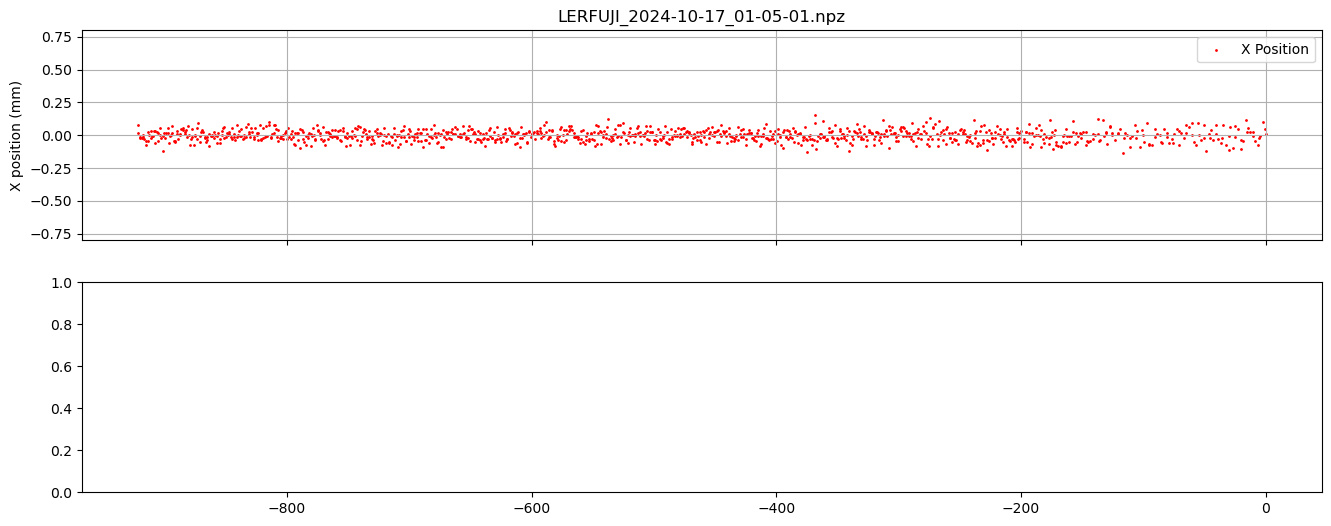

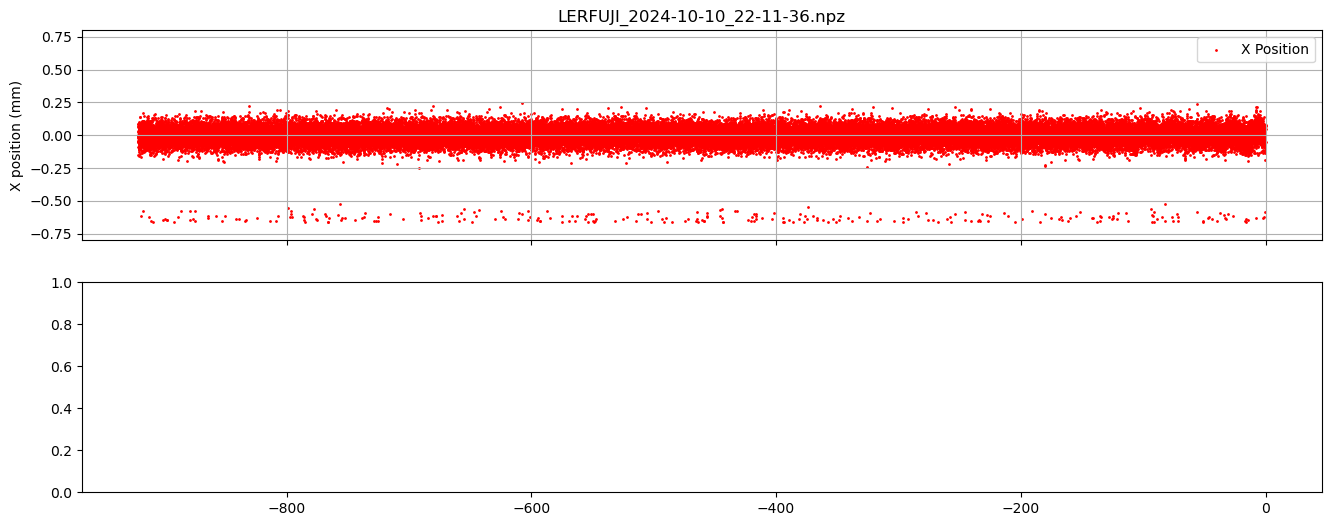

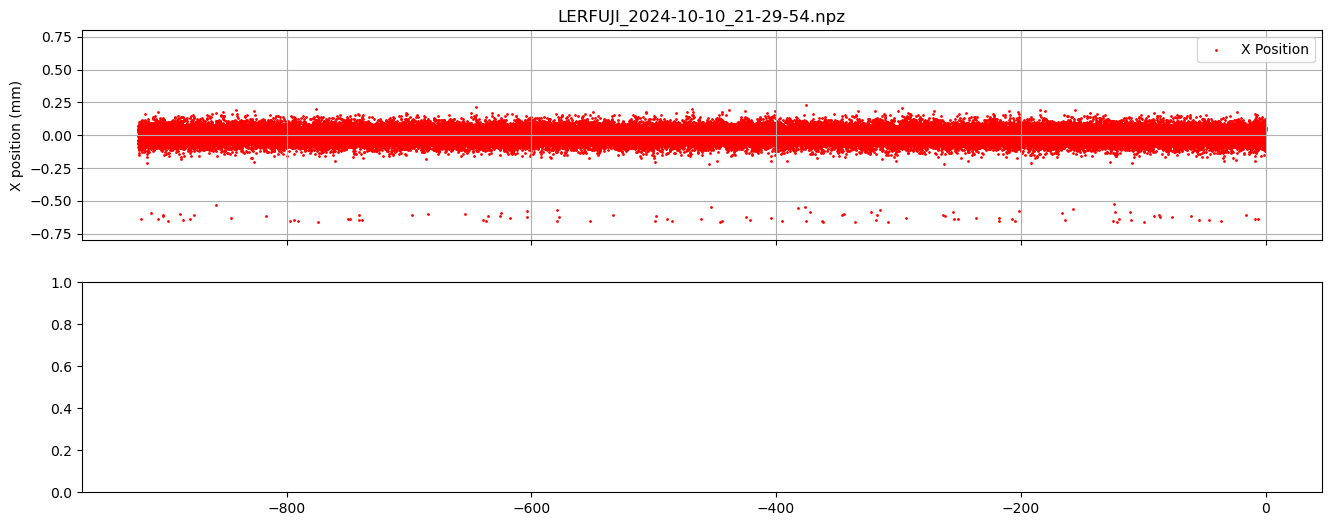

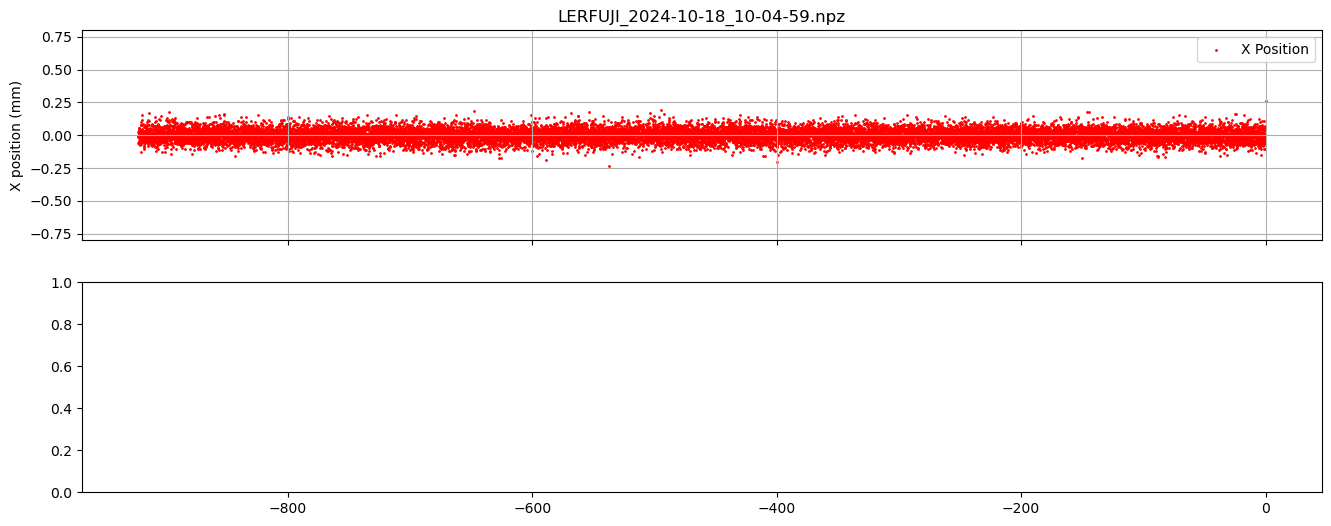

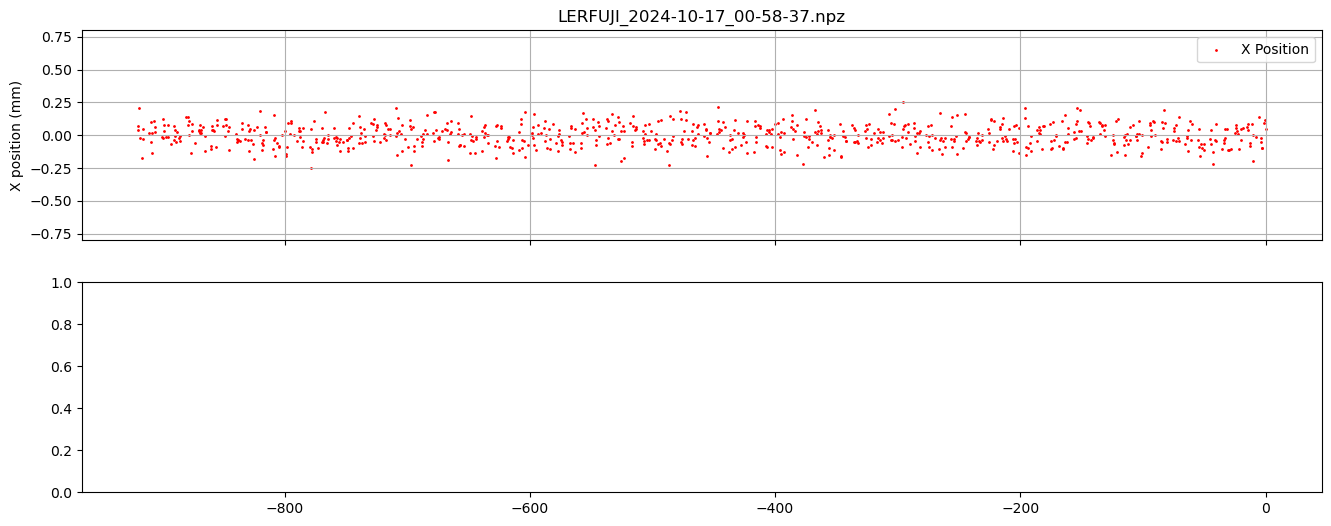

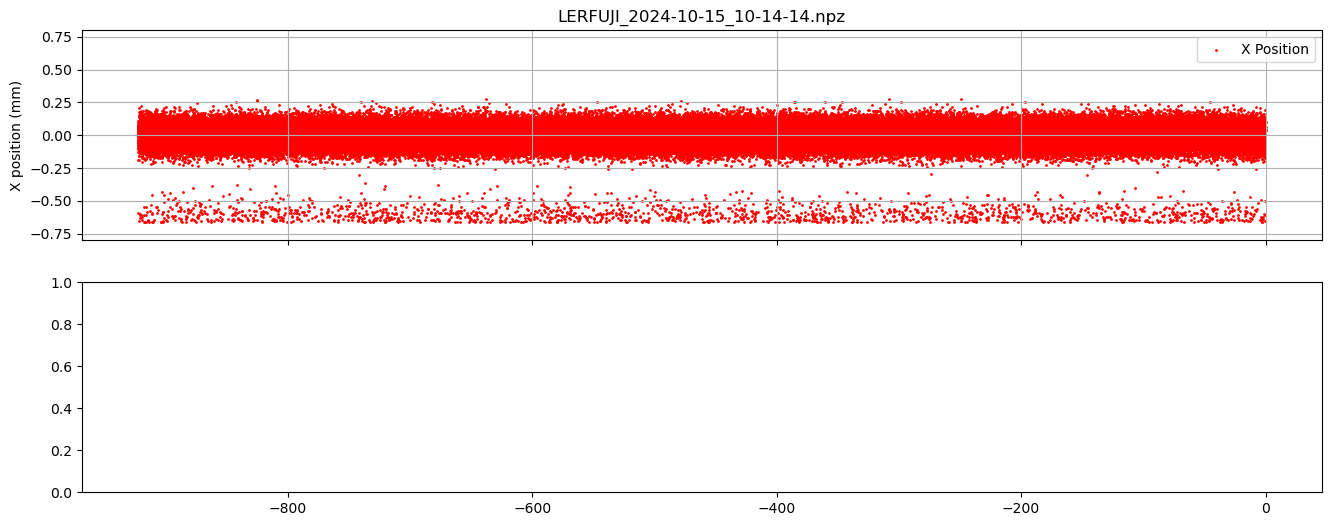

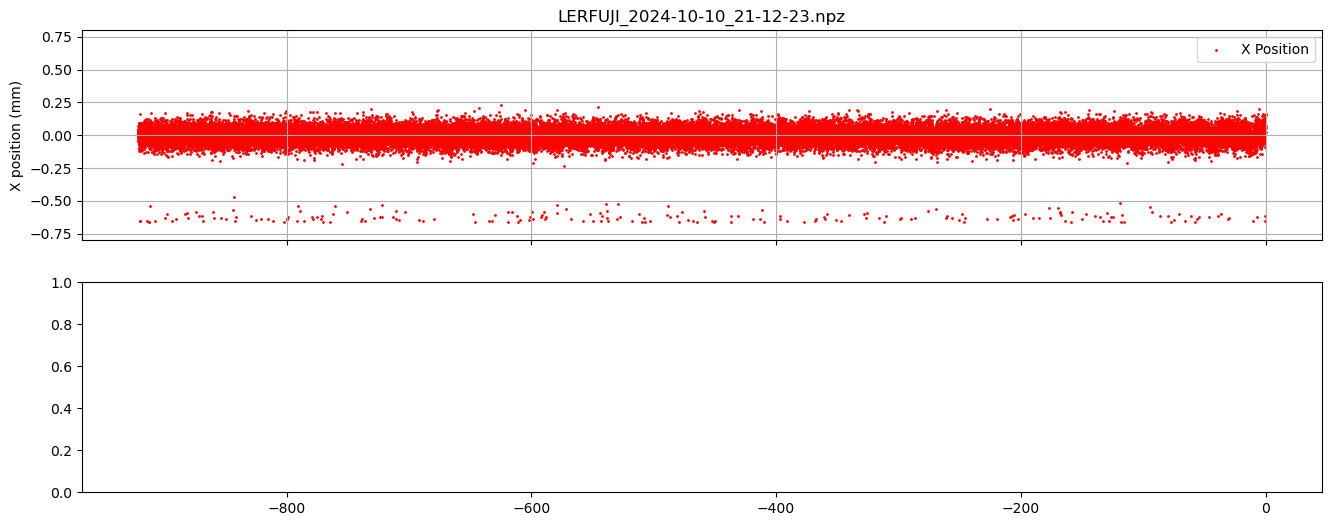

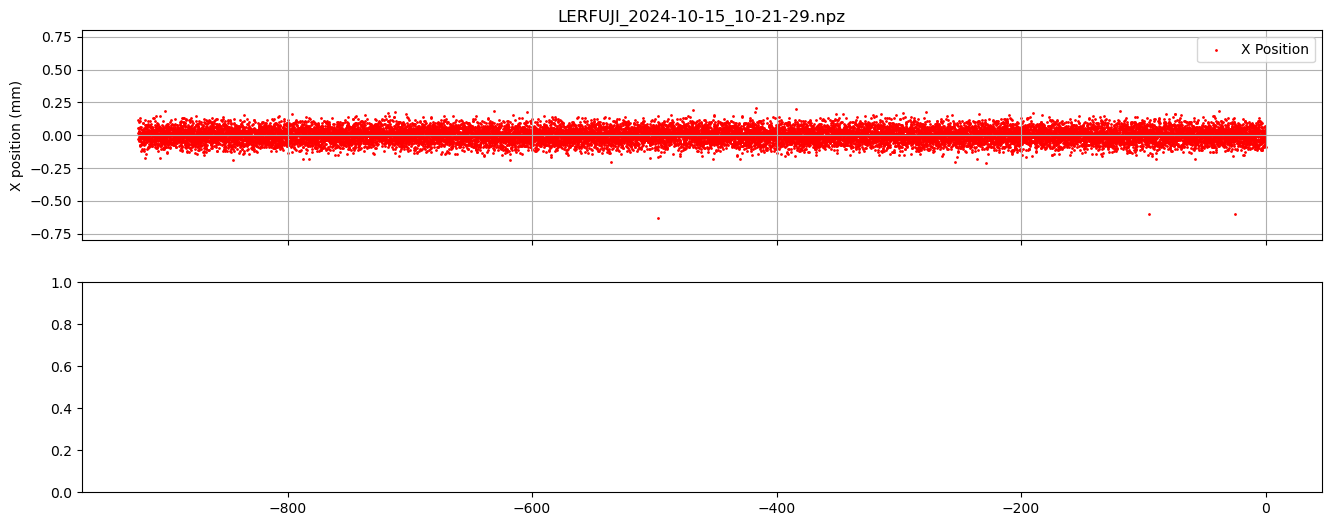

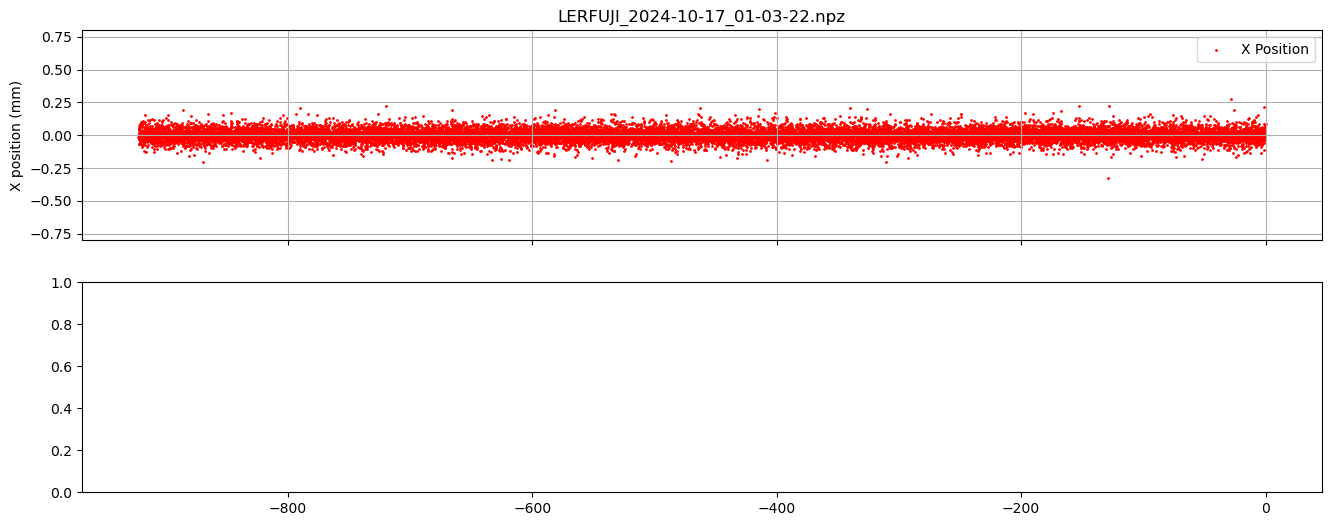

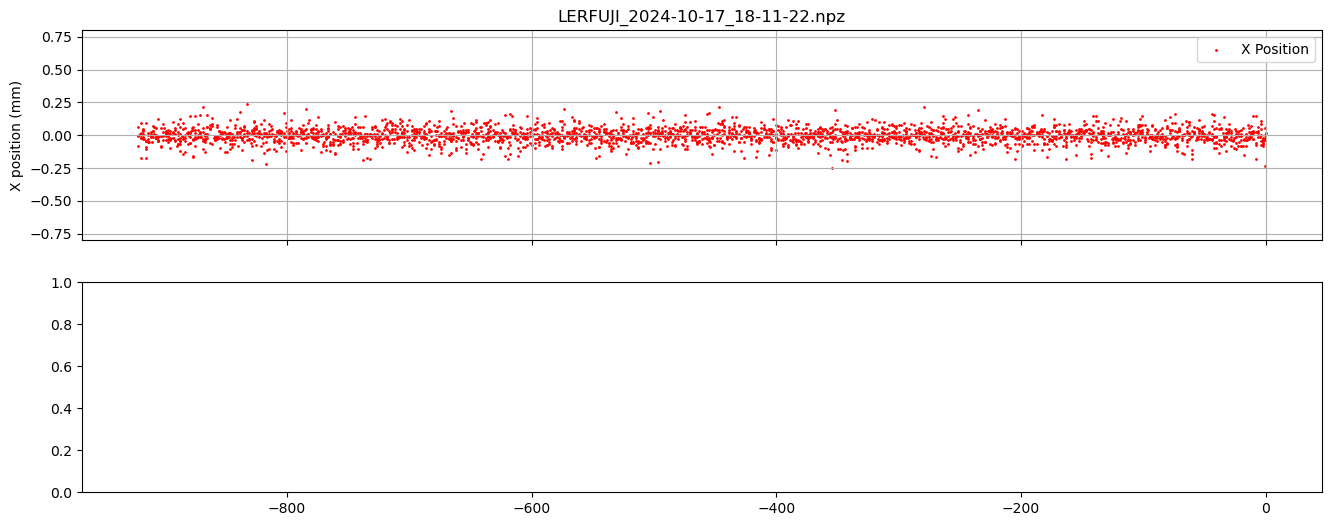

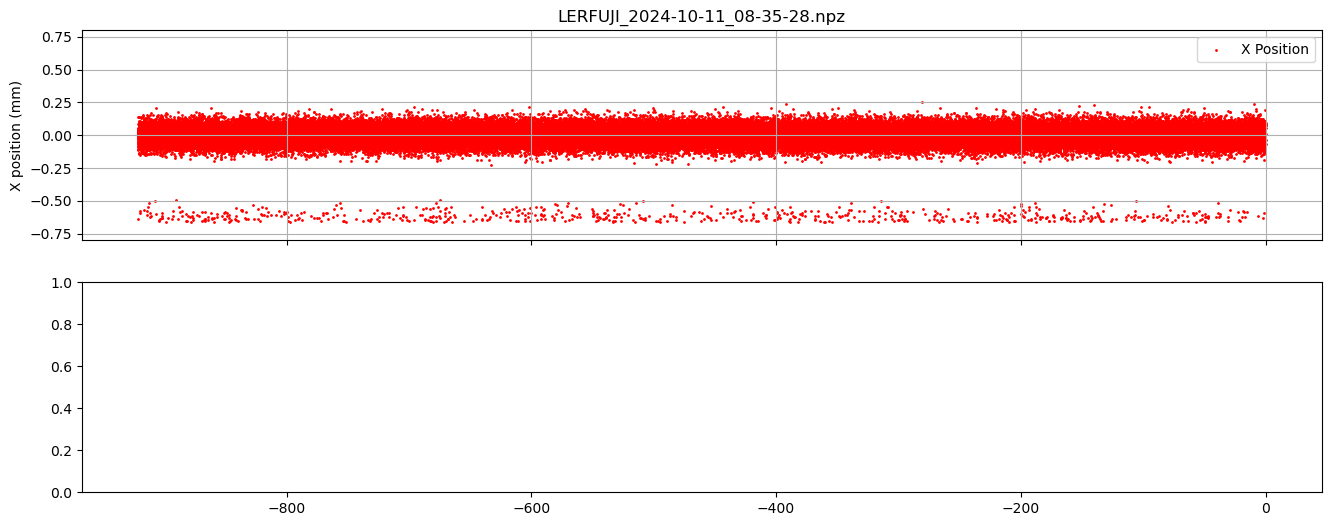

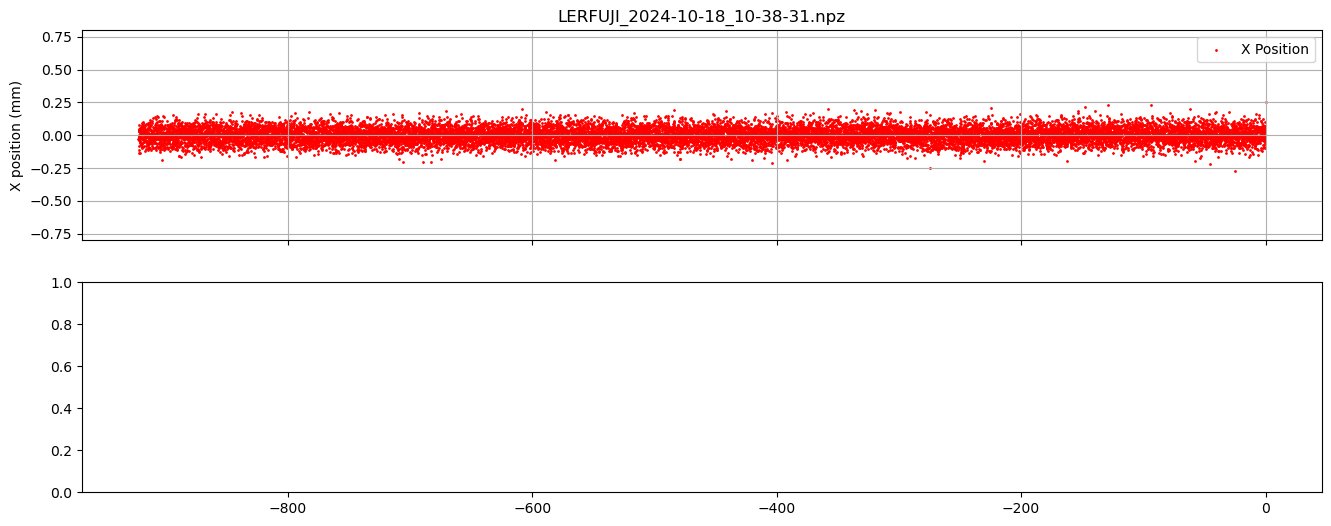

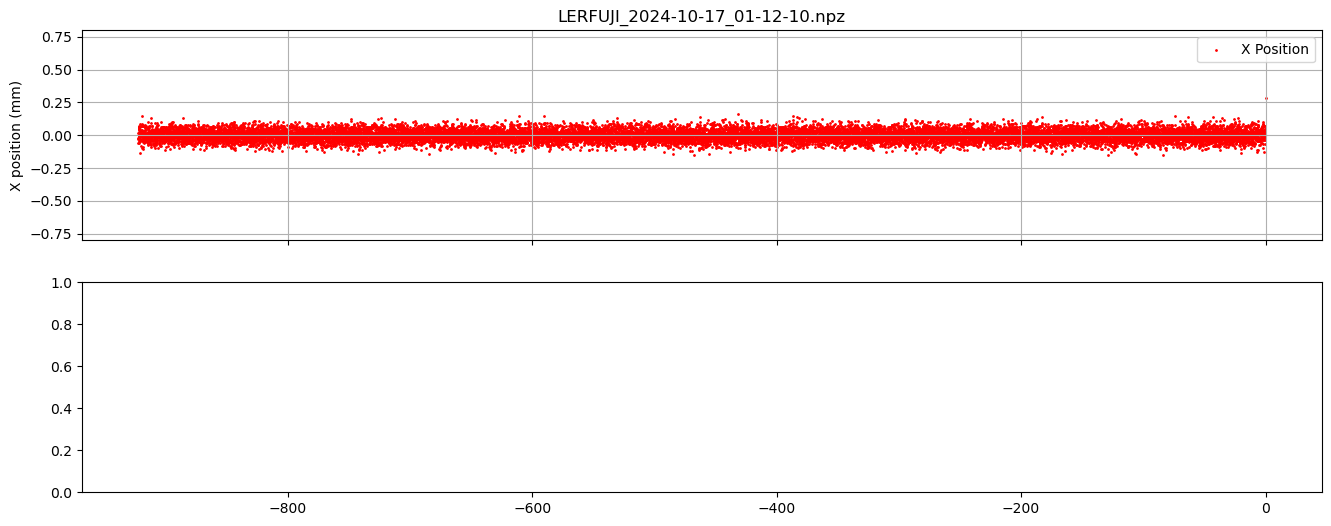

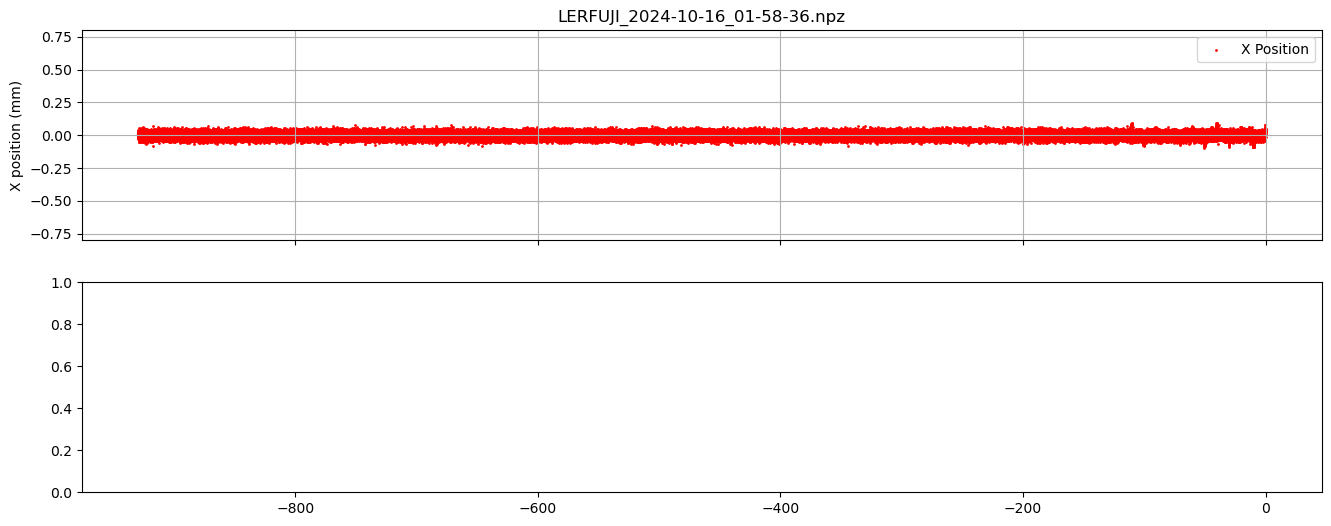

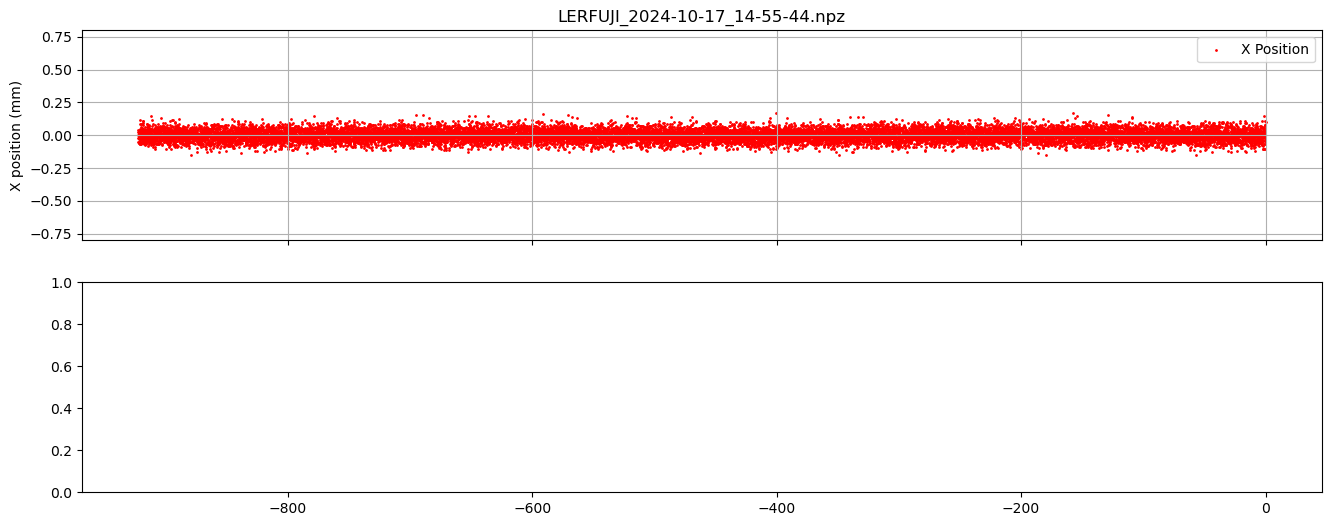

In [4]:
exceed_x=[]
exceed_y=[]
charge_loss=[]
shinpuku_x=[]
shinpuku_y=[]
time_axis=[]
spectrum=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'):
    print(i)
    a,b,c,d,e,f=make_mastdplot(i)
    exceed_x.append(a)
    exceed_y.append(b)
    shinpuku_x.append(c)
    shinpuku_y.append(d)
    time_axis.append(e)
    spectrum.append(f)

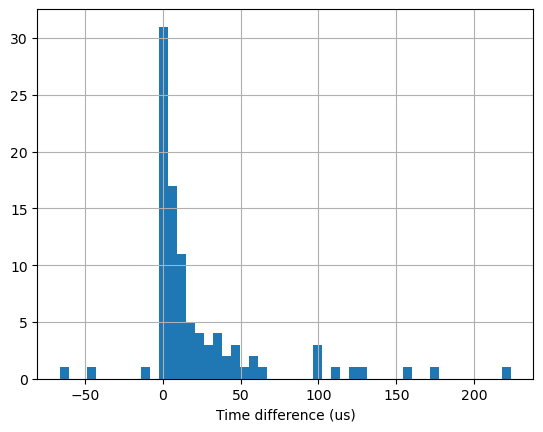

In [49]:
diff=np.array(exceed_y)-np.array(exceed_x)
diff[(exceed_x==0)&(exceed_y==0)]=np.nan
diff=diff[~np.isnan(diff)]
diff=diff[diff<300]



plt.hist(diff,bins=50)
#plt.xlim(-100,200)
plt.xlabel('Time difference (us)')
plt.grid()
plt.savefig('HV_timediff.png',dpi=100)
plt.show()

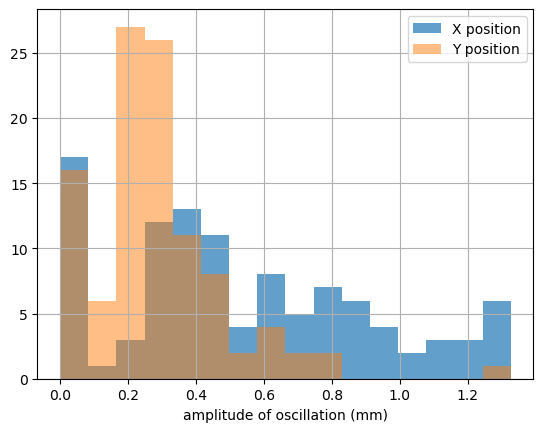

In [11]:
shinpuku_x[(exceed_x==0)&(exceed_y==0)]=np.nan
shinpuku_y[(exceed_x==0)&(exceed_y==0)]=np.nan
plt.hist(np.array(shinpuku_x)*16.58/5,bins=16,label='X position',alpha=0.7)
plt.hist(np.array(shinpuku_y)*16.58/5,bins=16,label='Y position',alpha=0.5)
plt.grid()
plt.legend()
plt.xlabel('amplitude of oscillation (mm)')
plt.savefig('amplitude.png',dpi=100)
plt.show()

In [5]:
len(time_axis)

106

In [6]:
len(spectrum)

106

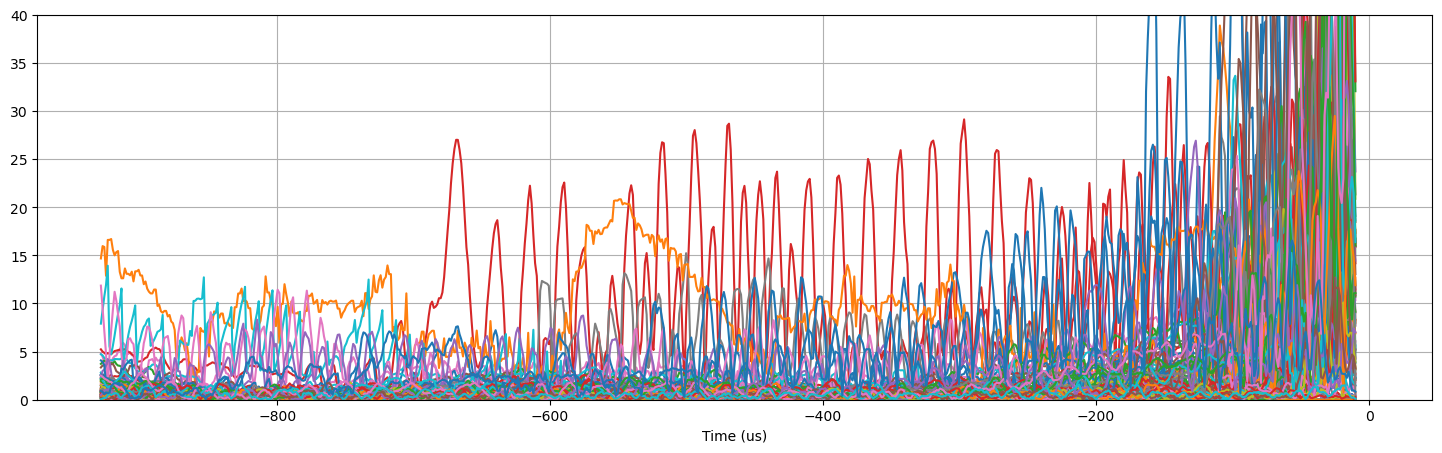

In [10]:
plt.figure(figsize=(18,5))
for i in range(len(time_axis)):
    if np.mean(spectrum[i][0:100])>10:
        continue
    plt.plot(time_axis[i],spectrum[i])
plt.ylim(0,40)
plt.xlabel('Time (us)')
plt.grid()
plt.savefig('abort_spectrum.png',dpi=100)
plt.show()

In [14]:
len(exceed_y)

106

/tmp/ipykernel_3731348/3234357198.py:1: RuntimeWarning: divide by zero encountered in divide
  result=np.where(X_sum>500, X_delta/X_sum,0)


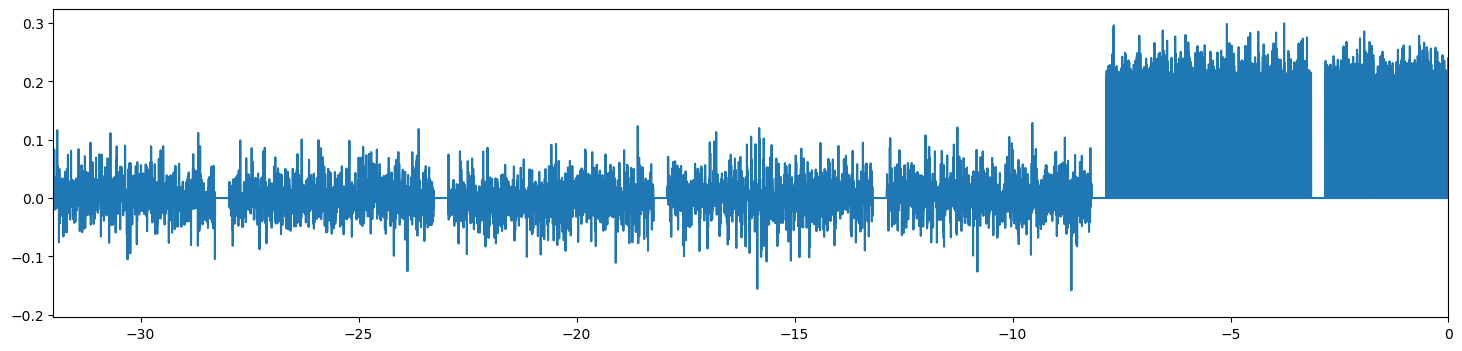

In [27]:
result=np.where(X_sum>500, X_delta/X_sum,0)
result=result[51200:]-result[:-51200]
timesteps=np.arange(len(result))/509
timesteps=timesteps-timesteps[-1]
plt.figure(figsize=(18,4))
plt.plot(timesteps,result)
plt.xlim(-32,0)
plt.show()

# Periodoc

In [2]:
def make_mastdplot(filename):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'+filename,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']
    X_pos=npz_kw['X_Pos']
    X_ma=npz_kw['X_MA']
    X_std=npz_kw['X_STD']
    #X_valid=npz_kw['X_valid']
    Y_pos=npz_kw['Y_Pos']
    Y_ma=npz_kw['Y_MA']
    Y_std=npz_kw['Y_STD']
    #Y_valid=npz_kw['Y_valid']
    #iv=npz_kw['Injection_Veto']
    abortflag=npz_kw['AbortFlag']


    timesteps=np.arange(len(X_pos))/254.5
    timesteps=timesteps-timesteps[-1]

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)
    #------------------
    signal = df['result_interp'].values
    signal=signal[~np.isnan(signal)]
    if len(signal)==0:
        return 0,0
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqs = fft_freqs[:len(fft_freqs)//2]
    positive_fft = np.abs(fft_result[:len(fft_result)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    condition = df['result_ma_diff'] > df['std_shifted']*0.5
    first_row = df[condition].head(1)
    # その行のColumn3の値を取得
    exceed_x=0
    if not first_row.empty:
        exceed_x = first_row['x'].values[0]

    if len(df)==0:
        return 0,0
    df['x']=df['x']-df['x'].iloc[-1]

    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,6))
    ax1.set_title(f'{filename}')
    #ax1.plot(timesteps,X_pos,label='X position')
    #ax1.plot(timesteps,X_ma/500,label='MA/500')
    #ax1.plot(timesteps,X_std/500,label='STD/500')
    #ax1.plot(timesteps,iv,label='injection veto')
    #ax1.plot(timesteps,abortflag/2,label='AbortFlag')

    ax1.plot(df['x'],df['result_diff'],label='X Position')
    ax1.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax1.plot(df['x'], df['std_shifted']*20, label='STD')
    
    ax1.set_ylim(-0.2,0.6)
    ax1.grid()
    ax1.set_ylabel('X position (a.u.)')
    ax1.legend()

    ####################
    
    #ax2.plot(timesteps,Y_pos,label='Y position')
    #ax2.plot(timesteps,Y_ma/500,label='MA/500')
    #ax2.plot(timesteps,Y_std/500,label='STD/500')
    #ax2.plot(timesteps,iv,label='injection veto')
    #ax2.plot(timesteps,abortflag/2,label='AbortFlag')

    
    df = pd.DataFrame({'x':timesteps2,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=4000
    # 条件に従って 'result' を計算
    df['result'] = np.where(df['Y_sum'] > threshold, df['Y_delta'] / df['Y_sum'], 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff'] = df['result'] - df['result'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff'] = np.where(abs(df['result_diff']) > 0.2, np.nan, df['result_diff'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff'] = np.where(df['Y_sum'] <= threshold, np.nan, df['result_diff'])
    df['result_interp']=df['result_diff'].interpolate(method='spline',order=2)
    #------------------
    signaly = df['result_interp'].values
    signaly=signaly[~np.isnan(signaly)]
    if len(signaly)==0:
        return 0,0
    fft_resulty = np.fft.fft(signaly)
    fft_freqsy = np.fft.fftfreq(len(signaly),d=1/509)
    # 正の周波数部分のみ抽出
    positive_freqsy = fft_freqsy[:len(fft_freqsy)//2]
    positive_ffty = np.abs(fft_resulty[:len(fft_resulty)//2])
    #-------------------
    df=df.dropna()
    # 移動平均と移動標準偏差を計算
    df['result_ma500'] = df['result_diff'].rolling(window=500).mean()
    df['result_ma10000'] = df['result_diff'].rolling(window=10000).mean()
    # window=500の移動平均を17行下にシフト
    df['result_ma500_shifted'] = df['result_ma500'].shift(17)
    # 二つの移動平均の差の絶対値を計算
    df['result_ma_diff'] = abs(df['result_ma500_shifted'] - df['result_ma10000'])
    df['result_std500'] = df['result_diff'].rolling(window=500).std()
    df['std_shifted']=df['result_std500'].shift(500)

    condition = df['result_ma_diff'] > df['std_shifted']*0.5
    first_row = df[condition].head(1)
    # その行のColumn3の値を取得
    exceed_y=0
    if not first_row.empty:
        exceed_y = first_row['x'].values[0]

    if len(df)==0:
        return 0, 0

    df['x']=df['x']-df['x'].iloc[-1]

    ax2.plot(df['x'],df['result_diff'],label='Y Position')
    ax2.plot(df['x'], df['result_ma_diff']*20, label='MA')
    ax2.plot(df['x'], df['std_shifted']*20, label='STD')

    ax2.grid()
    ax2.legend()
    ax2.set_ylim(-0.2,0.6)
    ax2.set_ylabel("Y position (a.u.)")
    plt.xlim(-800,0)
    ax2.set_xlabel("Time (us)")
    plt.savefig(f'periodic_picture/{filename[8:-4]}.png',dpi=100)
    #plt.show()
    plt.close()

    ######################################

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqs, positive_fft)
    plt.title('FFT of Xpos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    #plt.xscale('log')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fft.png',dpi=100)
    plt.close()



   # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signal
    x = np.arange(len(signal))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]#* window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)


    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Xpos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,50)
    # プロット表示
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fft3Dx.png',dpi=100)
    plt.close()

    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Xpos')

    plt.ylim(240,254)
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fftheatmapx.png',dpi=100)
    plt.close()

    time_axis=window_times-window_times[-1]-10
    spectrum=fft_results.T[2508]
    plt.figure(figsize=(14,3))
    plt.plot(time_axis,spectrum,'o-')
    plt.ylim(0,10)
    plt.grid()
    plt.xlabel('Time (us)')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_amplitude_suii.png',dpi=100)
    plt.close()



    #print(fft_results)
    #plt.plot(fft_results.T[np.argmax(positive_fft[12:])+12])
    #plt.show()

    ######################################3

    plt.figure(figsize=(16,4))
    plt.plot(positive_freqsy, positive_ffty)
    plt.title('FFT of Ypos')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.grid(True)
    #plt.xscale('log')
    plt.savefig(f'periodic_picture/{filename[8:-4]}_ffty.png',dpi=100)
    plt.close()
    
    
    # サンプリング周波数
    Fs = 509
    # ウィンドウサイズとシフトサイズ（少しずつ動かす）
    window_size = 5120
    step_size = 640
    # データの準備
    data = signaly
    x = np.arange(len(signaly))/509
    # 窓関数（ハニング窓などを使用する）
    window = get_window('hann', window_size)
    # FFT結果を保存するリスト
    fft_results = []
    # ウィンドウの中心時間を保存するリスト
    window_times = []
    # データをウィンドウに分割してFFT
    for start in range(0, len(data) - window_size, step_size):
        # ウィンドウデータの抽出
        window_data = data[start:start + window_size]# * window
        # FFTの計算
        fft_result = np.abs(fft(window_data))[:window_size // 2]  # FFTの前半だけ使う（対称性を利用）
        # 周波数軸の計算
        freqs = np.fft.fftfreq(window_size, d=1/Fs)[:window_size // 2]
        # FFT結果の保存
        fft_results.append(fft_result)
        # ウィンドウの中心時間を計算して保存
        window_center_time = x[start + window_size]
        window_times.append(window_center_time)
    # ヒートマップ用にデータ整形
    fft_results = np.array(fft_results)

    # X, Y, Z 軸の値を作成
    X = np.arange(fft_results.shape[1])  # 周波数ビン (横軸)
    Y = np.arange(fft_results.shape[0])  # ウィンドウインデックス (縦軸)
    X, Y = np.meshgrid(X, Y)  # メッシュグリッドを作成
    Z = fft_results  # Z軸（振幅）はログスケールのFFT結果
    # 三次元プロットの設定
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    # 3Dの表面プロット
    surf = ax.plot_surface(X, Y, Z, cmap='terrain',vmin=0,vmax=10)
    # カラーバーの追加
    fig.colorbar(surf)
    # ラベル設定
    ax.set_title('FFT 3D Plot Ypos')
    ax.set_xlabel('Frequency Bins')
    ax.set_ylabel('Window Index')
    ax.set_zlabel('Amplitude')
    ax.set_zlim(0,10)
    # プロット表示
    plt.savefig(f'periodic_picture/{filename[8:-4]}_fft3Dy.png',dpi=100)
    plt.close()
    
    
    #fft_results = np.log(fft_results + 1e-10)
    plt.figure(figsize=(16, 8))
    plt.imshow(fft_results.T, cmap='magma', aspect='auto',
               vmin=0,vmax=4,
              extent=(window_times[0]-window_times[-1]-10,-10,freqs[-1],freqs[0]))  # Y軸のラベル数を減らす
    plt.colorbar(label='Amplitude')
    # 軸ラベル
    plt.xlabel('Time [us]')
    plt.ylabel('Frequency [MHz]')
    plt.title('Time-varying FFT Heatmap Ypos')

    plt.savefig(f'periodic_picture/{filename[8:-4]}_fftheatmapy.png',dpi=100)
    plt.close()


    return time_axis,spectrum

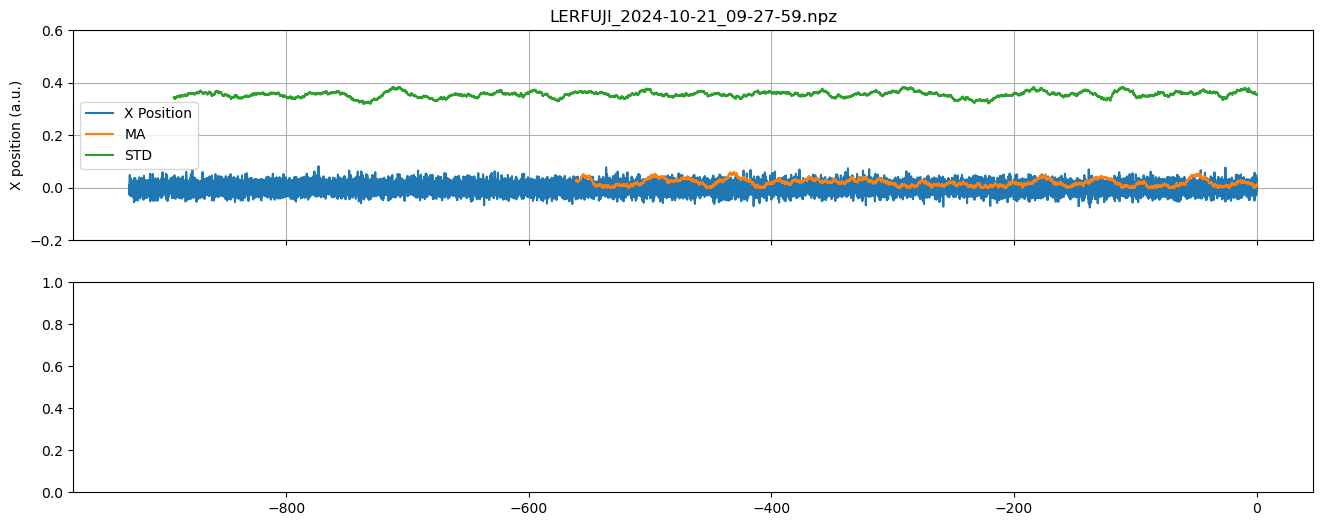

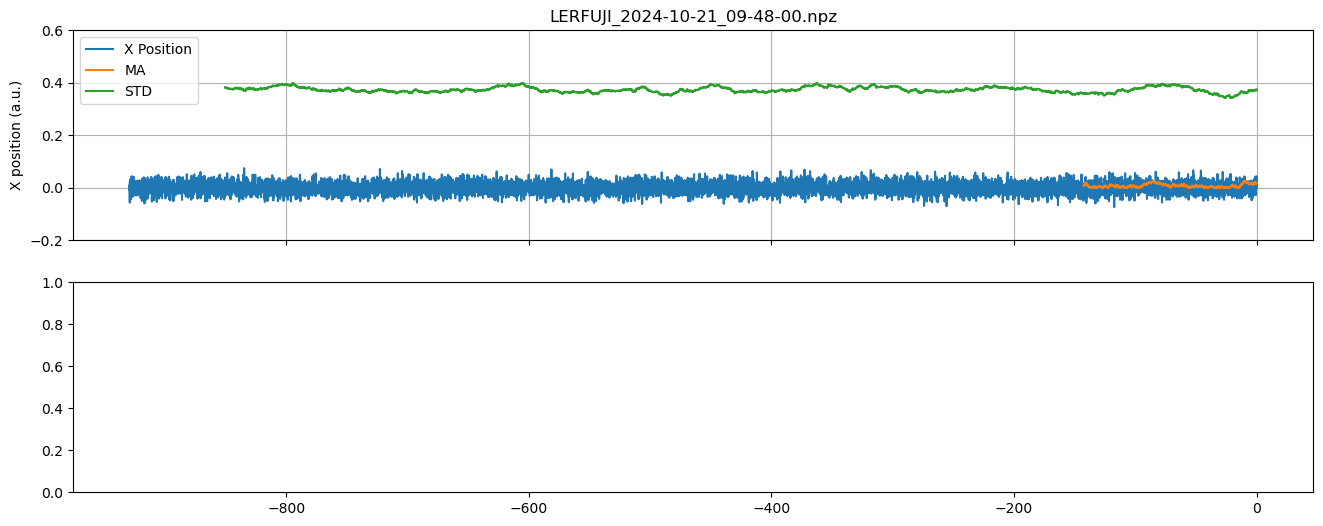

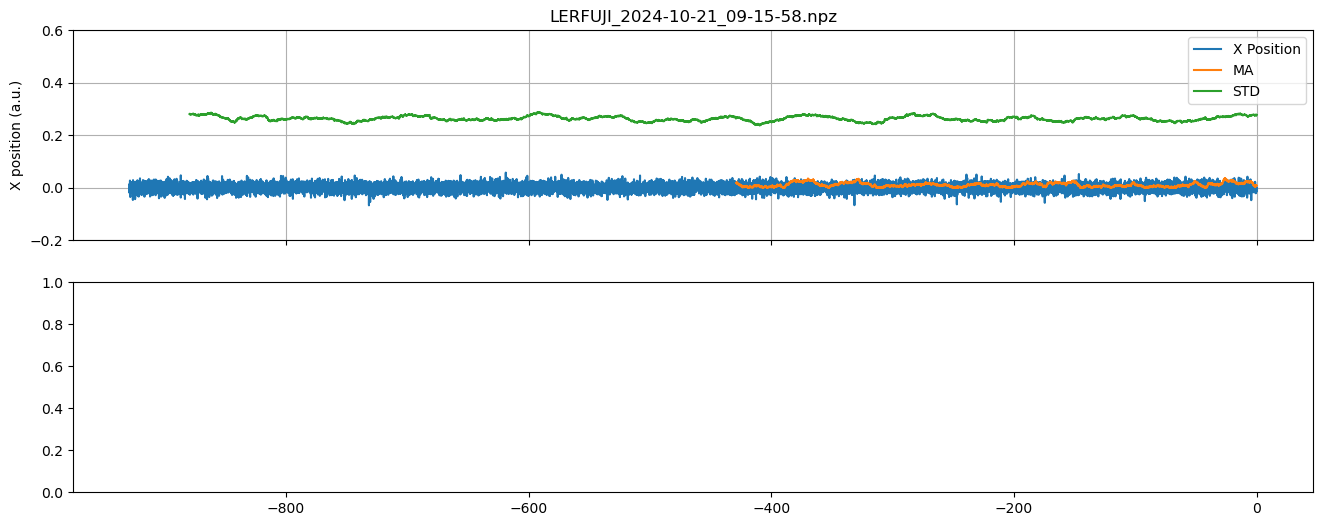

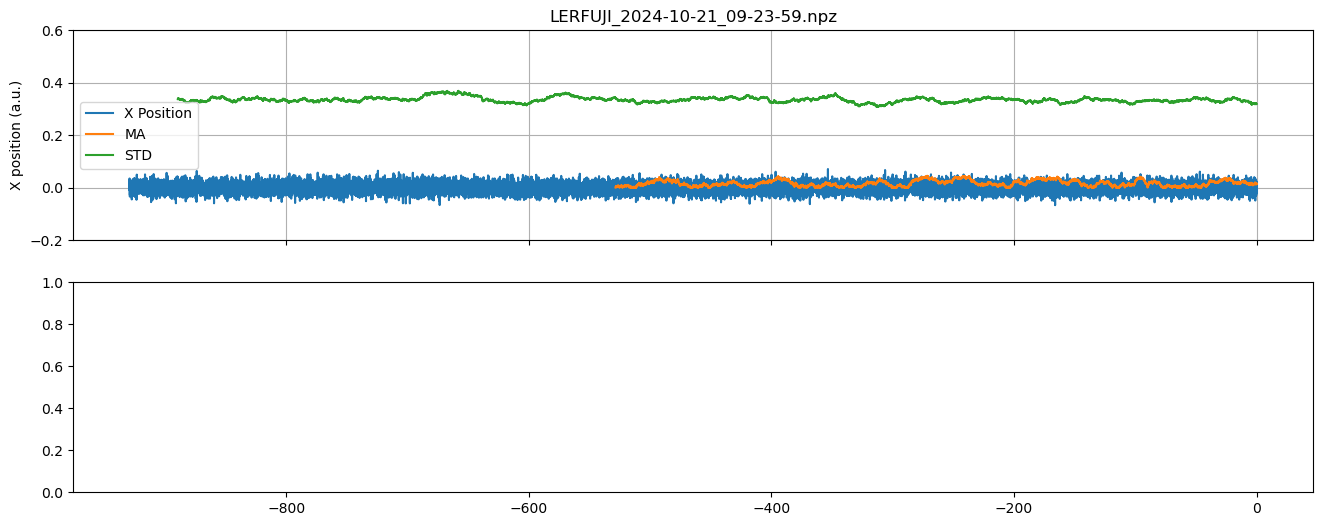

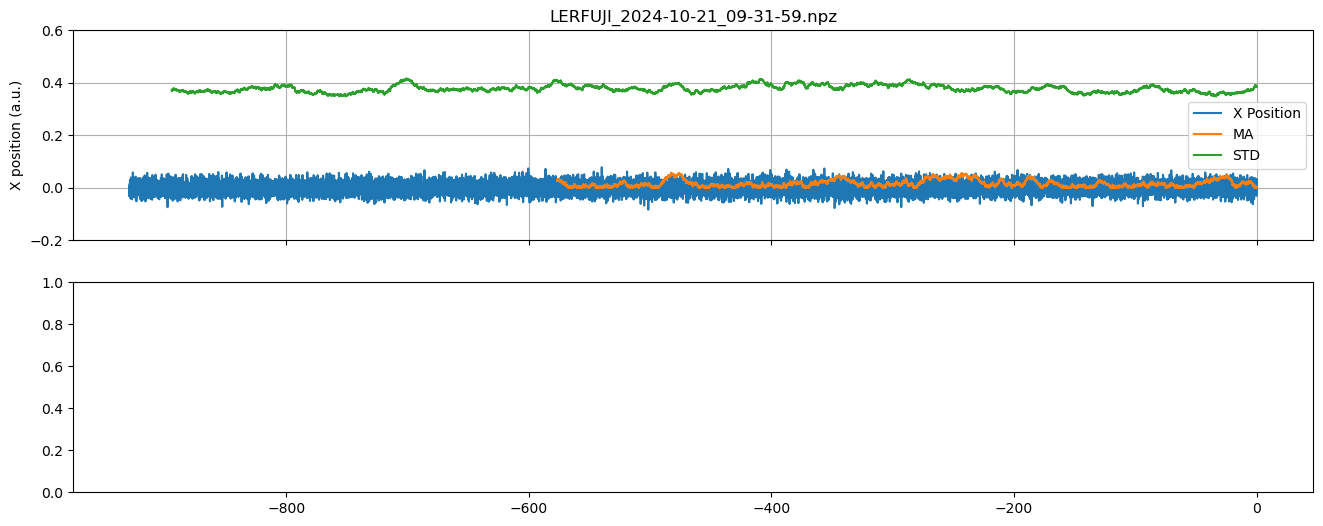

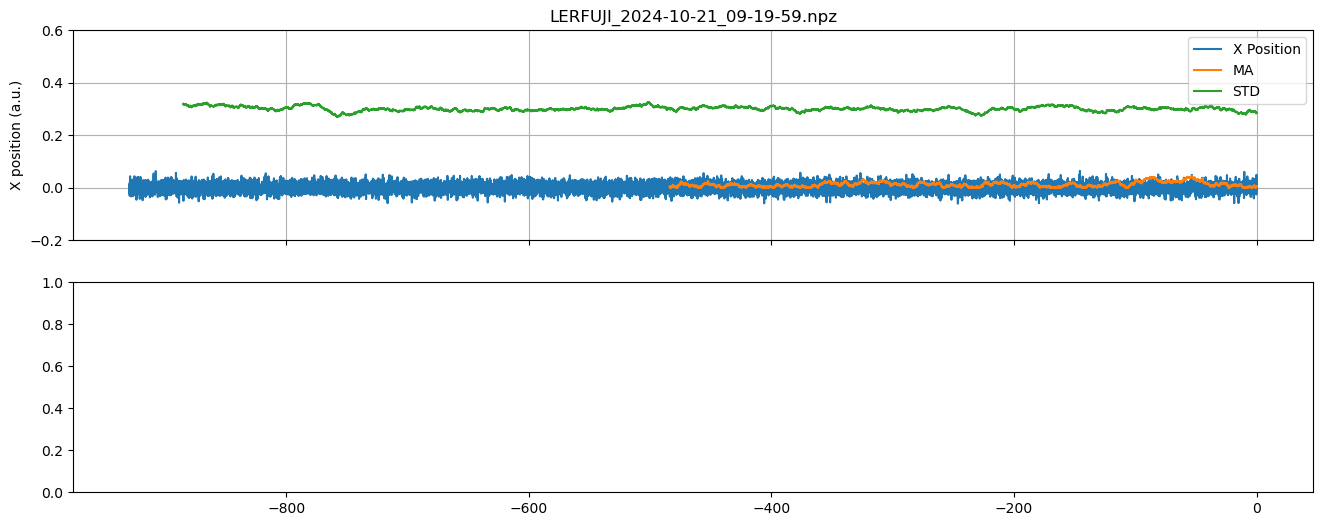

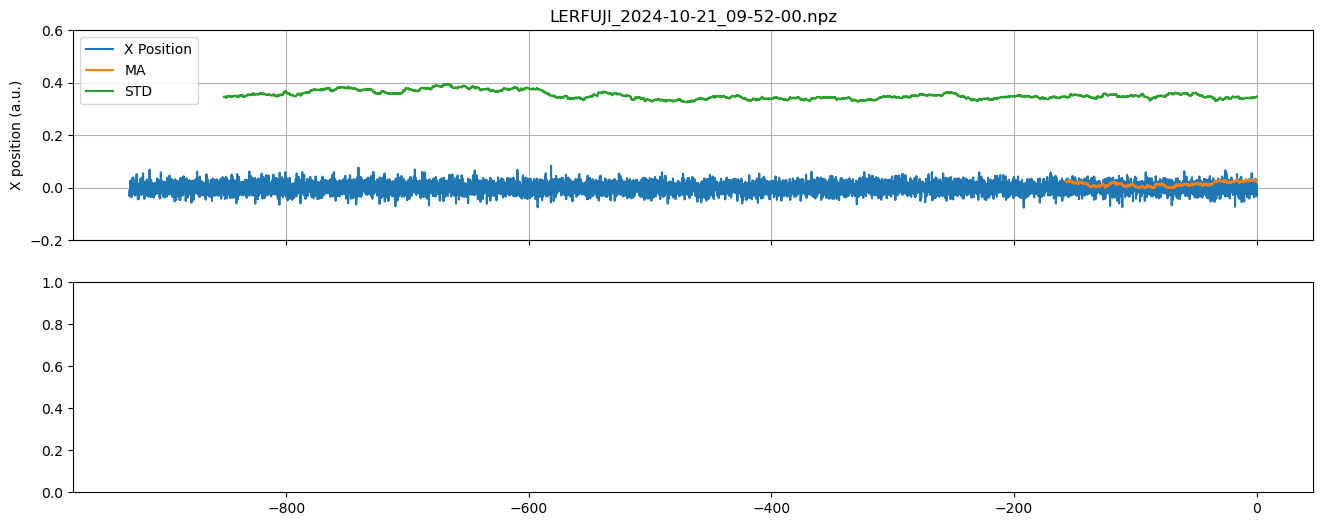

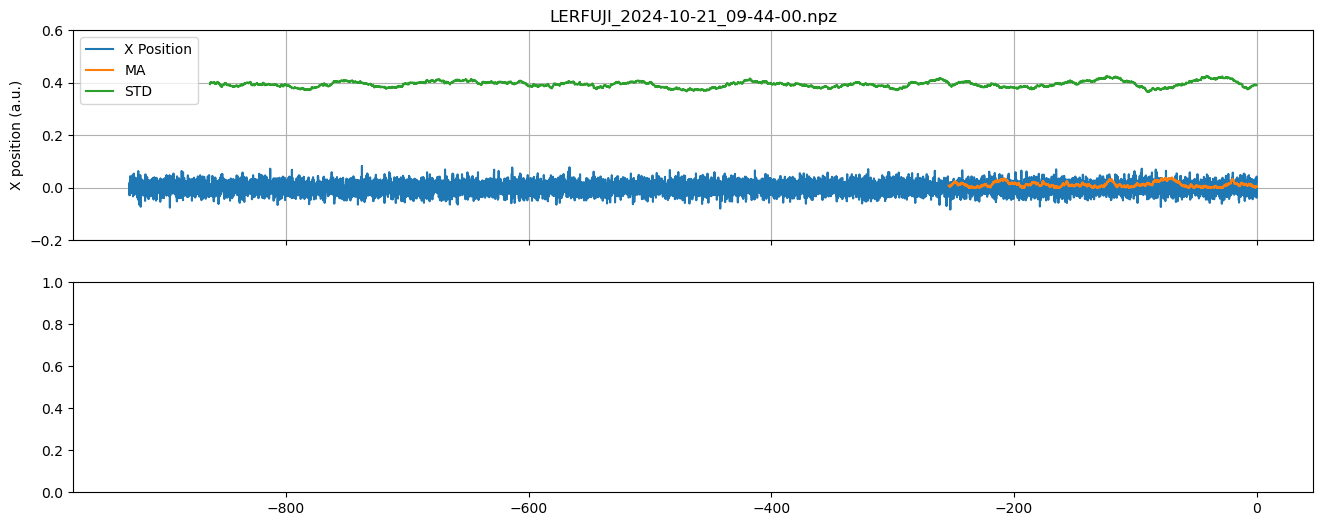

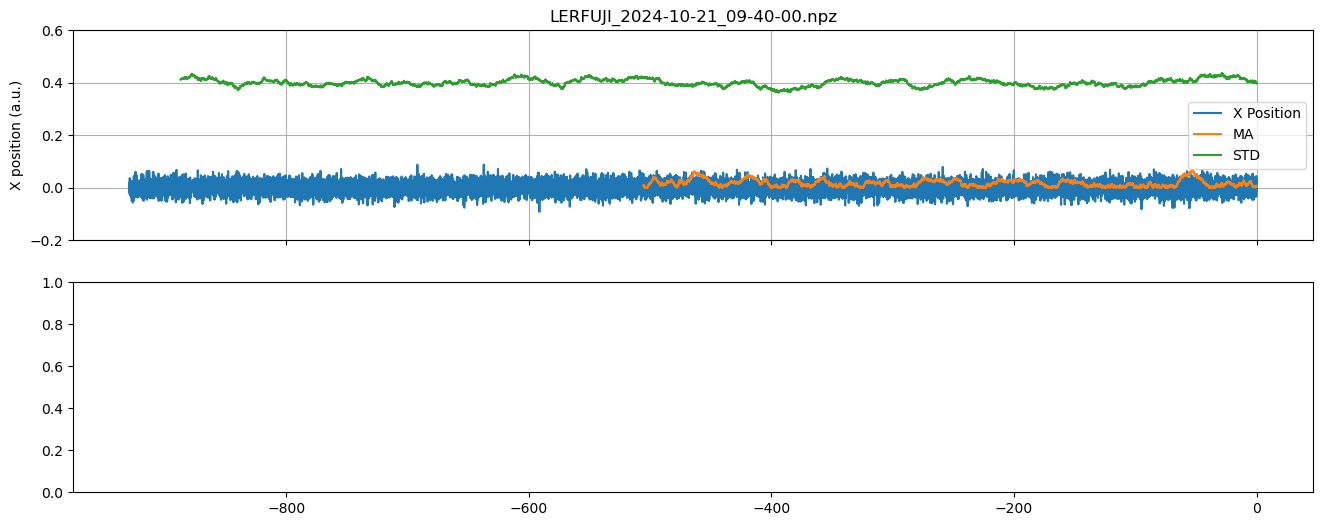

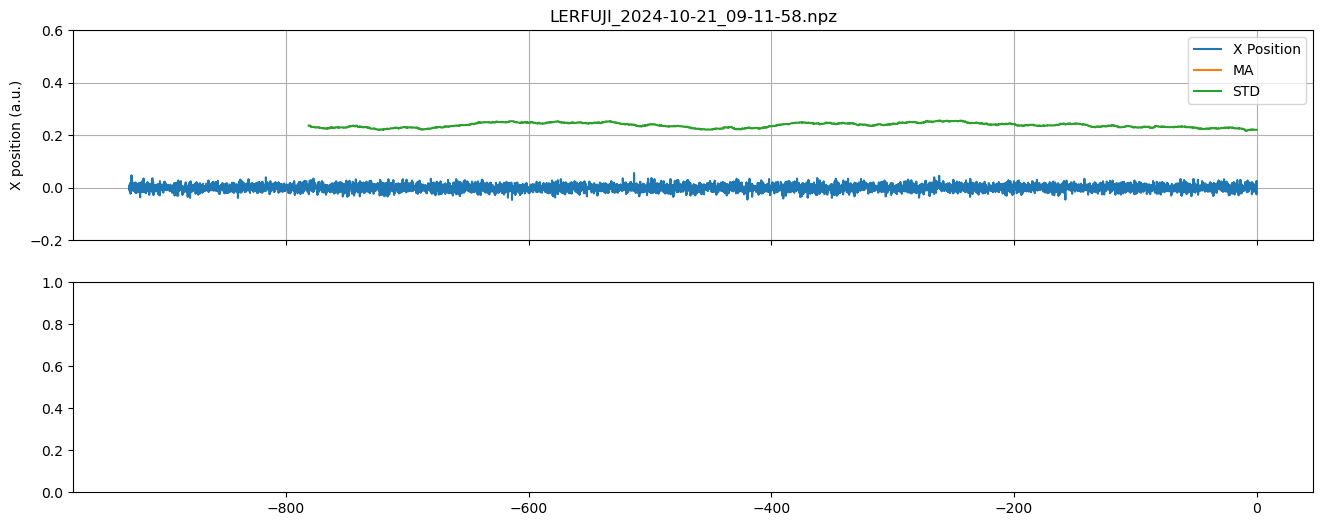

In [3]:
time_axis_periodic=[]
spectrum_periodoc=[]
for i in os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/Periodic/'):
    a,b=make_mastdplot(i)
    time_axis_periodic.append(a)
    spectrum_periodoc.append(b)

In [4]:
len(time_axis_periodic)

116

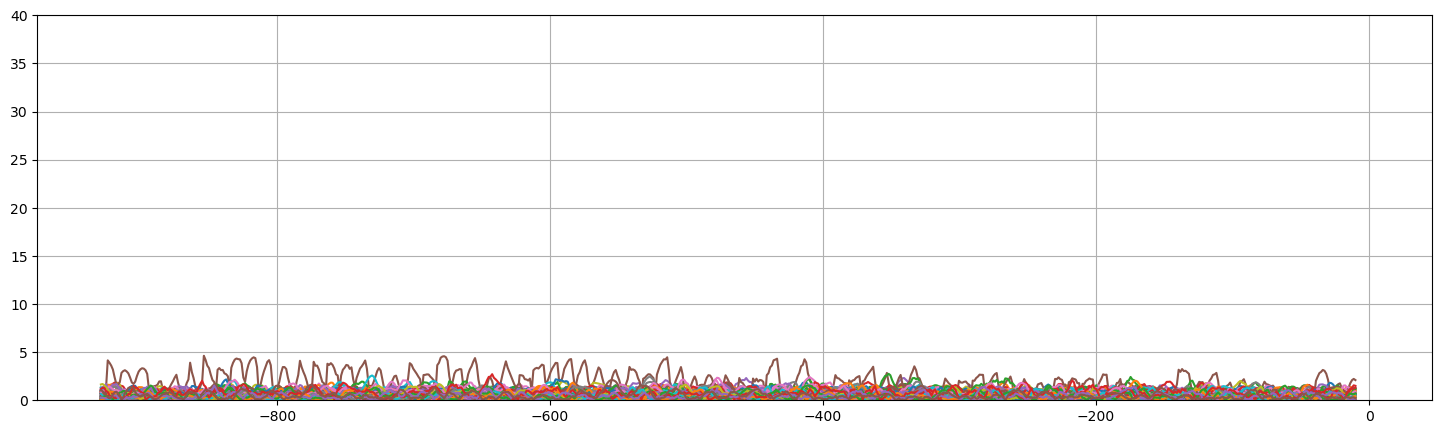

In [5]:
plt.figure(figsize=(18,5))
for i in range(len(time_axis_periodic)):
    plt.plot(time_axis_periodic[i],spectrum_periodoc[i])
plt.grid()
plt.ylim(0,40)
plt.savefig('periodoc_spectrum.png',dpi=100)
plt.show()
    